# Simple Moving Average (SMA) Strategy

## Introduction

The Simple Moving Average (SMA) strategy is a commonly used method in technical analysis to identify market trends. It relies on the idea that short-term and long-term moving averages can provide buy and sell signals based on their interactions.

## Basic Concept

### Simple Moving Average (SMA)

The simple moving average is an arithmetic mean of prices over a specified period. It is calculated by summing the closing prices over a specified period and dividing by the number of periods.

$$ \text{SMA} = \frac{\sum_{i=1}^{n} P_i}{n} $$

where $ P_i $ is the closing price at period $ i $ and $ n $ is the number of periods.

### SMA Strategy

The SMA strategy uses two moving averages:
- **Short SMA**: Moving average over a shorter time window (e.g., 5 days).
- **Long SMA**: Moving average over a longer time window (e.g., 20 days).

### Signal Generation

- **Buy Signal**: When the short SMA crosses above the long SMA, it indicates an uptrend and generates a buy signal (signal = 1).
- **Sell Signal**: When the short SMA crosses below the long SMA, it indicates a downtrend and generates a sell signal (signal = -1).

### Calculating Returns

Daily returns are calculated as the percentage change in prices from one day to the next. The strategy returns are obtained by multiplying the daily returns by the generated signals.

$$ \text{Daily Return} = \frac{P_t - P_{t-1}}{P_{t-1}} $$

where $ P_t $ is the closing price at period $ t $.

### Cumulative Performance

The cumulative performance of the strategy is calculated by multiplying the daily returns of the strategy and compounding them over the analysis period.

$$ \text{Cumulative Performance} = \left( \prod_{t=1}^{n} (1 + \text{Daily Return}_t) \right) - 1 $$

## Advantages and Disadvantages

### Advantages

- **Simplicity**: The SMA strategy is easy to understand and implement.
- **Effectiveness**: It can be effective in trending markets.

### Disadvantages

- **Lag**: Moving averages can lag behind actual price movements.
- **False Signals**: Can generate false signals in sideways markets.

## Goals

In this notebook, we will compare the performance of the SMA strategy on a clear trend versus a more trendless time series. For this, we will use **CAC40** (`^FCHI`) historical data as the clear trend time series and **Crude Oil Jan 25** (`CL=F`) as the unclear trend time series. 

By doing so, we aim to expose how the SMA strategy performs under different market conditions and identify its strengths and weaknesses.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
def test_sma_strategy(prices: pd.Series, short_window: int, long_window: int, allow_short=True) -> float:
    if len(prices) < max(short_window, long_window):
        raise ValueError("Time series is too short for the given SMA windows.")
    
    sma_short = prices.rolling(window=short_window).mean()
    sma_long = prices.rolling(window=long_window).mean()
    
    valid_idx = sma_short.index[max(short_window, long_window) - 1:]
    sma_short = sma_short.loc[valid_idx]
    sma_long = sma_long.loc[valid_idx]
    prices = prices.loc[valid_idx]
    
    
    signals = np.where(sma_short > sma_long, 1, -1)
    if not allow_short:
        signals = np.where(signals == -1, 0, signals)

    
    daily_returns = prices.pct_change().shift(-1).loc[valid_idx]
    
    strategy_returns = daily_returns[:-1] * signals[:-1]  # Align returns and signals
    cumulative_performance = (1 + strategy_returns).prod() - 1
    
    return cumulative_performance.values[0] * 100

def optimize_sma(prices: pd.Series, short_range: range, long_range: range, allow_short = True) -> dict:
    best_performance = -np.inf
    best_params = None
    results = []
    
    for short_window in short_range:
        for long_window in long_range:
            if short_window >= long_window:
                continue
            try:
                performance = test_sma_strategy(prices, short_window, long_window, allow_short = allow_short)
                results.append((short_window, long_window, performance))
                if performance > best_performance:
                    best_performance = performance
                    best_params = (short_window, long_window)
            except ValueError:
                continue

    return {"best_params": best_params, "best_performance": best_performance, "results": results}    

In [3]:
# Download CAC 40 historical data
ticker_oil = 'CL=F'
ticker_cac = '^FCHI'

In [4]:
oil = yf.download(ticker_oil, start="2015-01-01")['Close']
cac = yf.download(ticker_cac, start="2015-01-01")['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
oil_perf = ((oil.iloc[-1] / oil.iloc[0] - 1) * 100) .values[0]
cac_perf = ((cac.iloc[-1] / cac.iloc[0] - 1) * 100) .values[0]

In [6]:
# Define ranges for short and long windows
short_range = range(5, 50, 1)
long_range = range(50, 200, 5)

Best Parameters: Short Window = 34, Long Window = 135
Best Performance: 119.56%
Buy and hold Performance: 35.09%
Absolute SMA performance : 84.47%


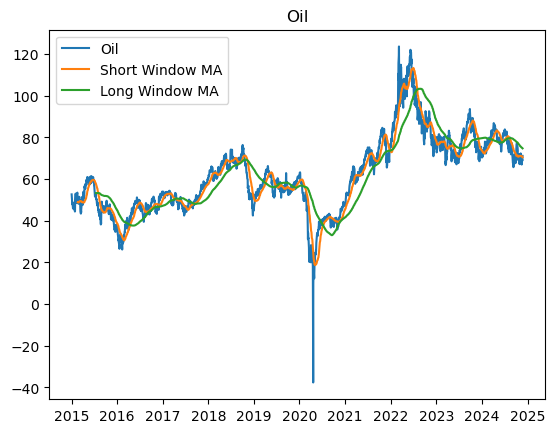

Best Parameters: Short Window = 17, Long Window = 165
Best Performance: 50.71%
Buy and hold Performance: 70.61%
Absolute SMA performance : -19.90%


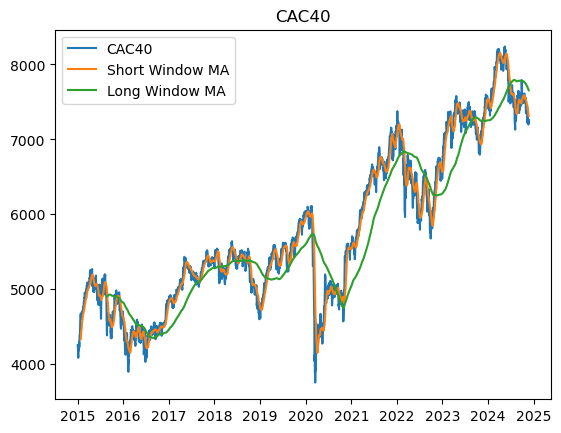

In [7]:

# Optimize SMA strategy
for data, index_perf, index_name in zip([oil, cac], [oil_perf, cac_perf], ['Oil', 'CAC40']):
    optimization_results = optimize_sma(data, short_range, long_range, allow_short = False)
    best_performance = optimization_results['best_performance']
    best_params = optimization_results['best_params']
    
    print(f"Best Parameters: Short Window = {best_params[0]}, Long Window = {best_params[1]}")
    print(f"Best Performance: {best_performance:.2f}%")
    print(f"Buy and hold Performance: {index_perf:.2f}%")
    
    abs_perf = (best_performance - index_perf)
    print(f"Absolute SMA performance : {abs_perf:.2f}%")
    
    # Plot the data and SMA strategy performance
    plt.plot(data, label= index_name)
    plt.plot(data.rolling(best_params[0]).mean(), label="Short Window MA")
    plt.plot(data.rolling(best_params[1]).mean(), label = "Long Window MA")
    plt.title(f"{index_name}")
    plt.legend()
    plt.show()

Best Parameters: Short Window = 34, Long Window = 135
Best Performance: 307.53%
Buy and hold Performance: 35.09%
Absolute SMA performance : 272.44%


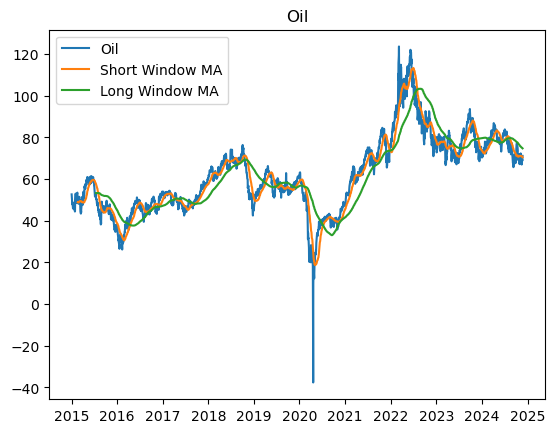

Best Parameters: Short Window = 17, Long Window = 165
Best Performance: 17.44%
Buy and hold Performance: 70.61%
Absolute SMA performance : -53.18%


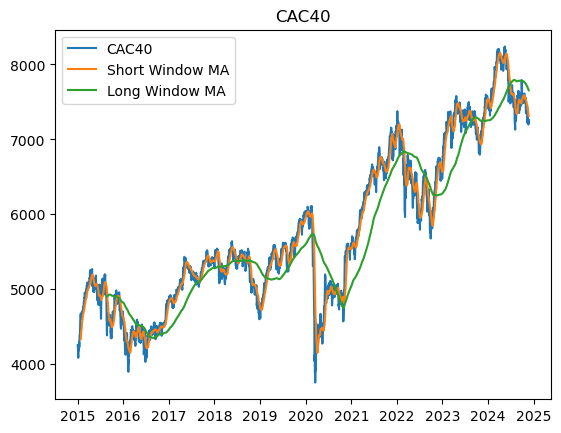

In [8]:
for data, index_perf, index_name in zip([oil, cac], [oil_perf, cac_perf], ['Oil', 'CAC40']):
    optimization_results = optimize_sma(data, short_range, long_range, allow_short = True)
    best_performance = optimization_results['best_performance']
    best_params = optimization_results['best_params']
    
    print(f"Best Parameters: Short Window = {best_params[0]}, Long Window = {best_params[1]}")
    print(f"Best Performance: {best_performance:.2f}%")
    print(f"Buy and hold Performance: {index_perf:.2f}%")
    
    abs_perf = (best_performance - index_perf)
    print(f"Absolute SMA performance : {abs_perf:.2f}%")
    
    # Plot the data and SMA strategy performance
    plt.plot(data, label= index_name)
    plt.plot(data.rolling(best_params[0]).mean(), label="Short Window MA")
    plt.plot(data.rolling(best_params[1]).mean(), label = "Long Window MA")
    plt.title(f"{index_name}")
    plt.legend()
    plt.show()

## Conclusion

The Simple Moving Average (SMA) strategy is a straightforward and effective method for identifying market trends. As demonstrated with the oil data, it can perform well on certain time series. However, caution is advised, especially when the market exhibits a clear and long-term trend, such as the CAC40. In such cases, the SMA strategy might generate false signals, leading to suboptimal performance compared to a simple buy-and-hold strategy.

Additionally, it is important to note that in this notebook, we optimized the SMA windows using the entire available dataset. This approach is not feasible in a real-world implementation, where future data is unknown. Therefore, the results presented here primarily serve to illustrate the performance differences of the SMA strategy under varying market trends.

In summary, while the SMA strategy can be a valuable tool for trend identification, it should be used judiciously and in conjunction with other indicators and risk management techniques. Further research and backtesting on out-of-sample data are recommended to validate the strategy's effectiveness in real-world trading scenarios.
